# Chapter 5 - Convex Optimization #
&copy; 2022 Kenneth Winston

In the previous chapter we saw that finding a Markowitz efficient frontier in an equality-constrained setting was simple: just use Lagrange multipliers and specify a closed-form solution. But finding an efficient frontier got more complicated in Section 4.1.3 when the constraints were inequalities. The example we used there with only three assets was simple enough to think through explicitly. More generally with possibly thousands of assets and thousands of constraints, an algorithm is needed.

In this chapter we'll discuss **`optimization`**: the process of finding inputs that maximize or minimize a function (called the **`objective function`**) subject to constraints on the inputs. In quantitative finance, optimizations are used to find the best fits of parameters to data and to form optimal investment portfolios, among other uses.

Most quantitative finance practitioners and academics will not write their own optimization algorithms since most widely used computer languages already have extensive prepackaged optimization capabilities. However, most users of optimization packages can attest to the fact that "plug and chug" almost never works: the packages require sophisticated users who can understand (a) the best ways to present their problems; and (b) how to fix whatever (inevitably) goes wrong the first several times an optimization is attempted.

The aim of this chapter is to give the reader enough facility so that he or she can wrangle optimization packages into giving fast and accurate answers to the reader's problems. Readers wishing to gain enough facility so they can write their own optimization packages will need further development. Texts like Boyd and Vandenberghe[$^1$](#five_footnotes) and Bertsekas[$^2$](#five_footnotes) provide excellent further foundation in this area.

## 5.1 Basic Optimization Terminology ##

The **`gradient`** of a well-behaved (continuous, differentiable) function $f:\mathbb{R}^n\to \mathbb{R}$ is the column $n$-vector of partial derivatives:
$$grad(f)=\nabla f=\bigl(\frac{\partial f}{\partial x_1},\dots,\frac{\partial f}{\partial x_n}\bigr)^{\intercal}$$
The **`Hessian matrix`** of this function is (if it's twice differentiable):
$$
 \nabla^2 f\equiv \nabla \nabla^{\intercal} f =
  \left[ {\begin{array}{ccc}
   \frac{\partial^2 f}{\partial x_1^2} & \ddots & \frac{\partial^2 f}{\partial x_1\partial x_n}\\
    \vdots & \cdots & \vdots \\
   \frac{\partial^2 f}{\partial x_n\partial x_1} & \ddots & \frac{\partial^2 f}{\partial x_n^2}\\
  \end{array} } \right]
$$
Note the $\nabla$ operator produces an $n\times1$ vector, so to produce the $n\times n$ Hessian matrix the notation should be $\nabla \nabla^{\intercal} f$. However the usual notation is $\nabla^2 f$, or $\nabla^2 f(x)$ to indicate that the Hessian is evaluated at the specific point $x$.

A point $x_m$ is a **`local minimum`** of a function $f$ if and only if for all small positive scalars $d$,
$$f(x_m+e)\geq f(x_m) \quad\forall e | e^{\intercal}e<d\label{eq:local_minimum}\tag{5.1}$$
A **`local maximum`** is defined analogously. A point is an **`extremum`** (or just **`extreme`**) if it is a minimum or a maximum.

If $x_m$ is a local minimum of the function $f$ then it's a local maximum of the function $-f$, so we'll assume without loss of generality that we're looking for minima. If the idea is to get more of a good thing, then a procedure that gets less of the opposite of the good thing will get to the same place.

Suppose a point $x_m$ is a local minimum of $f$. Let $d_k$ be the vector of all $0$'s except for a one in the $k^{th}$ place. By definition
$$\frac{\partial f}{\partial x_k}(x_m)=\text{lim}_{\delta\to0}\frac{f(x_m+\delta d_k)-f(x_m)}{\delta}\label{eq:critical_limit}\tag{5.2}$$
Since $x_m$ is a local minimum, the numerator of the limit in \eqref{eq:critical_limit} is always non-negative for small enough $\delta$. Approaching $x_m$ from positive $\delta$ decreasing to zero gives a positive denominator in \eqref{eq:critical_limit} so $\frac{\partial f}{\partial x_k}(x_m)\geq0$. Approaching $x_m$ from negative $\delta$ increasing to zero gives a negative denominator in \eqref{eq:critical_limit} so $\frac{\partial f}{\partial x_k}(x_m)\leq0$. Since $f$ is differentiable, the direction of approach to $x_m$ doesn't matter. The only way the gradient can be both $\geq0$ and $\leq0$ is for it to equal zero.

The previous paragraph therefore shows that any local minimum (and analogously any local maximum) of a differentiable function $f$ must be a **`critical point`** of $f$, i.e. a point where the gradient of $f$ is the zero vector. 

Differentiability is theoretically important here: for example, $f(x)=\mid{x}\mid$ has a local (and global) minimum at $x=0$, but $x=0$ isn't a critical point because there isn't a critical point. In practice differentiability might not be so important as bumpy functions can usually be approximated by smooth functions to arbitrary accuracy. For example $f_a(x)=x\cdot \text{tanh}(ax)$ gets closer and closer to $\mid{x}\mid$ as $a\to\infty$, but it is differentiable and has a critical point at $x=0$.

The other direction isn't generally true: a critical point of a differentiable function might not be a local extremum. A critical point might be a **`saddle point`** where it's a minimum along one direction of travel and a maximum along another direction.

Generally it will be desirable to find a global minimum point $x_M$ such that
$$f(x_M)\leq f(x)\quad\forall x$$
Clearly global extrema are local extrema but not necessarily vice versa.

A generic optimization problem looks like
$$\text{minimize}_{x} f(x)$$
$$\text{subject to }g(x)=0\label{eq:generic_optimization}\tag{5.3}$$
$$\text{and }h(x)\geq0$$

$f(x)$ (a scalar function of $x\in\mathbb{R}^n$) is called the **`objective function`**. The "subject to" lines are called **`constraints`**. $g(x)$ is a vector-valued function so $g(x)=0$ can comprise multiple scalar equalities; the $g(x)=0$ requirements are called **`equality constraints`**. Similarly $h(x)$ is a vector-valued function and $h(x)\geq0$ are called **`inequality constraints`**. A point $x$ that satisfies all the constraints is said to be **`feasibile`**.

The formulation \eqref{eq:generic_optimization} is mildly redundant; the equality constraints are not really needed because they could be encoded in components of $h$. If $g_1(x)$ is a scalar function and the constraint $g_1(x)=0$ is desired, then one component of the vector-valued function $h$ could be $g_1$ and another component could be $-g_1$. It will be algorithmically convenient, however, to separate out the equality constraints from the inequality constraints.

## 5.2 Convex Properties ##

A major problem in the optimization of complicated functions is getting stuck at a local extremum that is not a global extremum. An algorithm might check that a small step in any direction away from the point goes up, indicating that the point is a local minimum. But without an exhaustive search, an algorithm can't know that there isn't an even deeper well beyond the next hill.

However this problem disappears when the objective function of an optimization is convex, i.e. where
$$f(\theta x + (1-\theta)y)\leq\theta f(x)+(1-\theta)f(y)\text{ for }0\leq\theta\leq1$$

>Property 5.1: Local minima are global minima for convex functions.

Proof: Suppose not: then let $x_m$ be a local minimum and $x_M$ a global minimum with $f(x_M)<f(x_m)$. Then take a combination $\theta x_m + (1-\theta)x_M$ where $\theta$ is close enough to $1$ so that the combination is still within the area around $x_m$ where $x_m$ is a minimum. By convexity, $f(\theta x_m + (1-\theta)x_M)\leq\theta f(x_m)+(1-\theta)f(x_M)<\theta f(x_m)+(1-\theta)f(x_m)=f(x_m)$. This violates $x_m$'s local minimality, which is a contradiction. That forces $f(x_M)=f(x_m)$ so the local minimum is a global minimum. (End Property 5.1 proof).

Property 5.1 is enormously helpful, as it means that checking locally suffices to find a global minimum when $f$ is convex. Convex functions have other powerful and useful properties:

>Property 5.2: If function $f$ is differentiable then it is convex if and only if
$$f(y)\geq f(x)+\nabla f(x)^{\intercal}(y-x)\label{eq:convex_grad_property}\tag{5.4}$$

Proof: Note that by the definition of convexity, 
$$f(x+\epsilon(y-x))=f(\epsilon y + (1-\epsilon)x)\leq\epsilon f(y)+(1-\epsilon)f(x)$$
So
$$f(x+\epsilon(y-x))-f(x)\leq\epsilon(f(y)-f(x))$$
Dividing by $\epsilon>0$ and taking the limit as $\epsilon\to0$ proves convexity implies \eqref{eq:convex_grad_property}.

To prove \eqref{eq:convex_grad_property} implies convexity, let $z$ be some point on the line segment between $x$ and $y$. That is, $z=\theta x+(1-\theta)y$, where $0\leq \theta\leq1$. Then by \eqref{eq:convex_grad_property}, $f(y)\geq f(z)+(\nabla f(z))^{\intercal}(y-z)$ and $f(x)\geq f(z)+(\nabla f(z))^{\intercal}(x-z)$. Multiply these two inequalities by $1-\theta$ and $\theta$, respectively, and add them together. The gradient term drops out and leaves the desired convexity property. (End Property 5.2 proof).

The previous section noted the implication (local minimum) $\implies$ (critical point) for differentiable functions. Property 5.2 establishes the even better reverse implication (critical point) $\implies$ (global minimum) for convex differentiable functions. Together with Property 5.1, that establishes
>Property 5.3: For convex differentiable functions, points are critical if and only if they are global minima.

Convex functions also have a second derivative property when they are twice differentiable:
>Property 5.4: A twice differentiable function $f$ is convex if and only if its Hessian matrix is positive semidefinite.

Proof: Let $x$ and $y$ be arbitrary $n$-vectors, and let
$$g(x,y,\theta)=\theta f(x)+(1-\theta)f(y)-f(\theta x + (1-\theta)y)
\label{eq:g_def}\tag{5.5}$$
for $0\leq\theta\leq1$. A Taylor expansion of a scalar function $h$ about a point $x_0$ looks like
$$h(x)=h(x_0)+(\nabla h(x_0))^{\intercal}(x-x_0)
+\frac{1}{2}(x-x_0)^{\intercal}\nabla^2 h(x_0) (x-x_0)+\dots$$
Let $h(y)=g(x,y,\theta)$ and apply a Taylor expansion of $h(y)$ about $y=x$:
$$h(y)=g(x,y,\theta)=g(x,x,\theta)+\nabla_2 g(x,x,\theta)^{\intercal}(y-x)+
\frac{1}{2}(y-x)^{\intercal}\nabla_2^2 g(x,x,\theta)(y-x)+\dots$$
where $\nabla_2$ means the derivative is taken with respect to the second argument. It follows from the definition of $g$ that $g(x,x,\theta)=0$ and
$$\nabla_2 g(x,x,\theta)=(1-\theta)(\nabla f(y))_{y=x}-(1-\theta)\nabla f(\theta x + (1-\theta)y))_{y=x}=0$$
That leaves only the Hessian and higher terms. Note
$$\nabla_2^2 g(x,x,\theta)=(1-\theta)(\nabla^2 f(y))_{y=x}-(1-\theta)^2\nabla^2 f(\theta x + (1-\theta)y))_{y=x}=\theta(1-\theta)\nabla^2 f(x)$$
Thus
$$g(x,y,\theta)=\frac{\theta(1-\theta)}{2}(y-x)^{\intercal}\nabla^2f(x)(y-x)+\dots
\label{eq:gxy_hessian}\tag{5.6}$$
where the dots represent third-order and higher terms.
Suppose f is convex. Then $g(x,y,\theta)\geq0$ for $\theta$ in the unit interval. Set $y=x+\delta z$ where $z$ is an arbitrary $n$-vector and $\delta>0$ is a positive scalar. \eqref{eq:gxy_hessian} becomes
$$g(x,x+\delta z,\theta)=\frac{\theta(1-\theta)}{2}\delta^2 z^{\intercal}\nabla^2f(x)z+O(\delta^3)\label{eq:gxy_convex}\tag{5.7}$$
Both sides of \eqref{eq:gxy_convex} are non-negative by the assumed convexity of $f$. As $\delta\to0$, the $O(\delta^3)$ terms become negligible, so the other term must be non-negative. So if $\theta$ is not $0$ or $1$, we must have $𝑧^{\intercal} \nabla^2 f(x)z\geq0$ for any $x$ and $z$, proving that the Hessian is positive semidefinite.

For the other direction of Property 5.4, suppose the Hessian is positive semidefinite. Then note that the Mean Value Theorem says there is a $z$ between $x$ and $y$ such that
$$f(y)=f(x)+(\nabla f(x))^{\intercal}(y-x)+\frac{1}{2}(y-x)^{\intercal}\nabla^2 f(z)(y-x)\label{eq:mean_value_theorem}\tag{5.8}$$
Rearranging,
$$f(y)-f(x)-(\nabla f(x))^{\intercal}(y-x)=\frac{1}{2}(y-x)^{\intercal}\nabla^2 f(z)(y-x)\geq0\label{eq:pos_semi_convex}\tag{5.9}$$
where the latter inequality holds because of positive semidefiniteness. Applying Property 5.2 proves that $f$ is convex. (End Property 5.4 proof.)

If $f(x)$ is concave, then $g(x)=-f(x)$ is convex. So all the properties of convex functions work with obvious substitutions for concave functions: "maximize" replaces "minimize" and "negative semidefinite" replaces "positive semidefinite." The inequality in \eqref{eq:convex_grad_property} is reversed for concave functions.

Consider the following cautionary example: Idee Adynr is a billionaire whose utility function is $U(w,b)=(5w-w^2)(10b-b^2)$; $w$ is her wealth in billions of dollars and $b$ is the number of best friends she has. Idee wants to maximize her utility.

To stay with our convention of minimizing, let $f(w,b)=-U(w,b)$, i.e. the objective will be to minimize Idee's disutility. The gradient is:
$$\nabla f(w,b)=
  \left[ {\begin{array}{c}
   \frac{\partial f}{\partial w} \\
   \frac{\partial f}{\partial b}  \\
  \end{array} } \right]
=
  \left[ {\begin{array}{c}
  -(5-2w)(10b-b^2)  \\
  -(5w-w^2)(10-2b)  \\
  \end{array} } \right]
$$
Thus the critical point $\nabla f=0$ when she has $w=\$2.5$ billion wealth and $b=5$ best friends. The code segment shows how to use a standard scipy.optimize function to find the critical point using a numerical (conjugate gradient) method:

In [11]:
#Optimize Idee's utility function
import numpy as np
import scipy.optimize as scpo

def util(params):
    w,b=params
#Want to maximize utility, so minimize -disutility
    ufunc=(5*w-w**2)*(10*b-b**2)
    return(-ufunc)

#initial guess for parameters
init_params=[1.,0.]
#Run the minimization.
results = scpo.minimize(util,init_params,method='CG')
wealth, friends = results.x
print("Critical point wealth = %.1f, friends = %.1f" % (wealth, friends))
print("Objective function at critical point: %.2f" % results.fun)

Critical point wealth = 2.5, friends = 5.0
Objective function at critical point: -156.25


The Hessian of Idee's disutility function is
$$
 \nabla^2 f =
  \left[ {\begin{array}{cc}
   \frac{\partial^2 f}{\partial w^2} &  \frac{\partial^2 f}{\partial w\partial b}\\
   \frac{\partial^2 f}{\partial b\partial w} & \frac{\partial^2 f}{\partial b^2}\\
  \end{array} } \right]
=
  \left[ {\begin{array}{cc}
   2(10b-b^2) & -2(5-2w)(5-b) \\
   -2(5-2w)(5-b) & 2(5w-w^2)\\
  \end{array} } \right]
$$

At the critical point $w=2.5$, $b=5$, the Hessian evaluates to
$$
 \nabla^2 f =
  \left[ {\begin{array}{cc}
   50 & 0 \\
   0 & 12.5\\
  \end{array} } \right]
$$
which is positive definite. So Idee's disutility function is convex at the critical point, and $\$2.5$ billion and $5$ best friends is a local disutility minimum, i.e. a local utility maximum. At the critical point, the disutility function is $-156.25$.

But the objective function is not globally convex. When both wealth $w$ and best friends $b$ are large, the curvature reverses. In fact Idee can have arbitrarily large utility (arbitrarily large negative disutility) by having huge amounts of money and huge numbers of friends. For example at $w=7$, $b=12$, the disutility is $-336$, i.e. this is preferable to the critical point $w=2.5$, $b=5$. At $(7,12)$ the Hessian has one positive and one negative eigenvalue. We can see this in Figure 5.1:

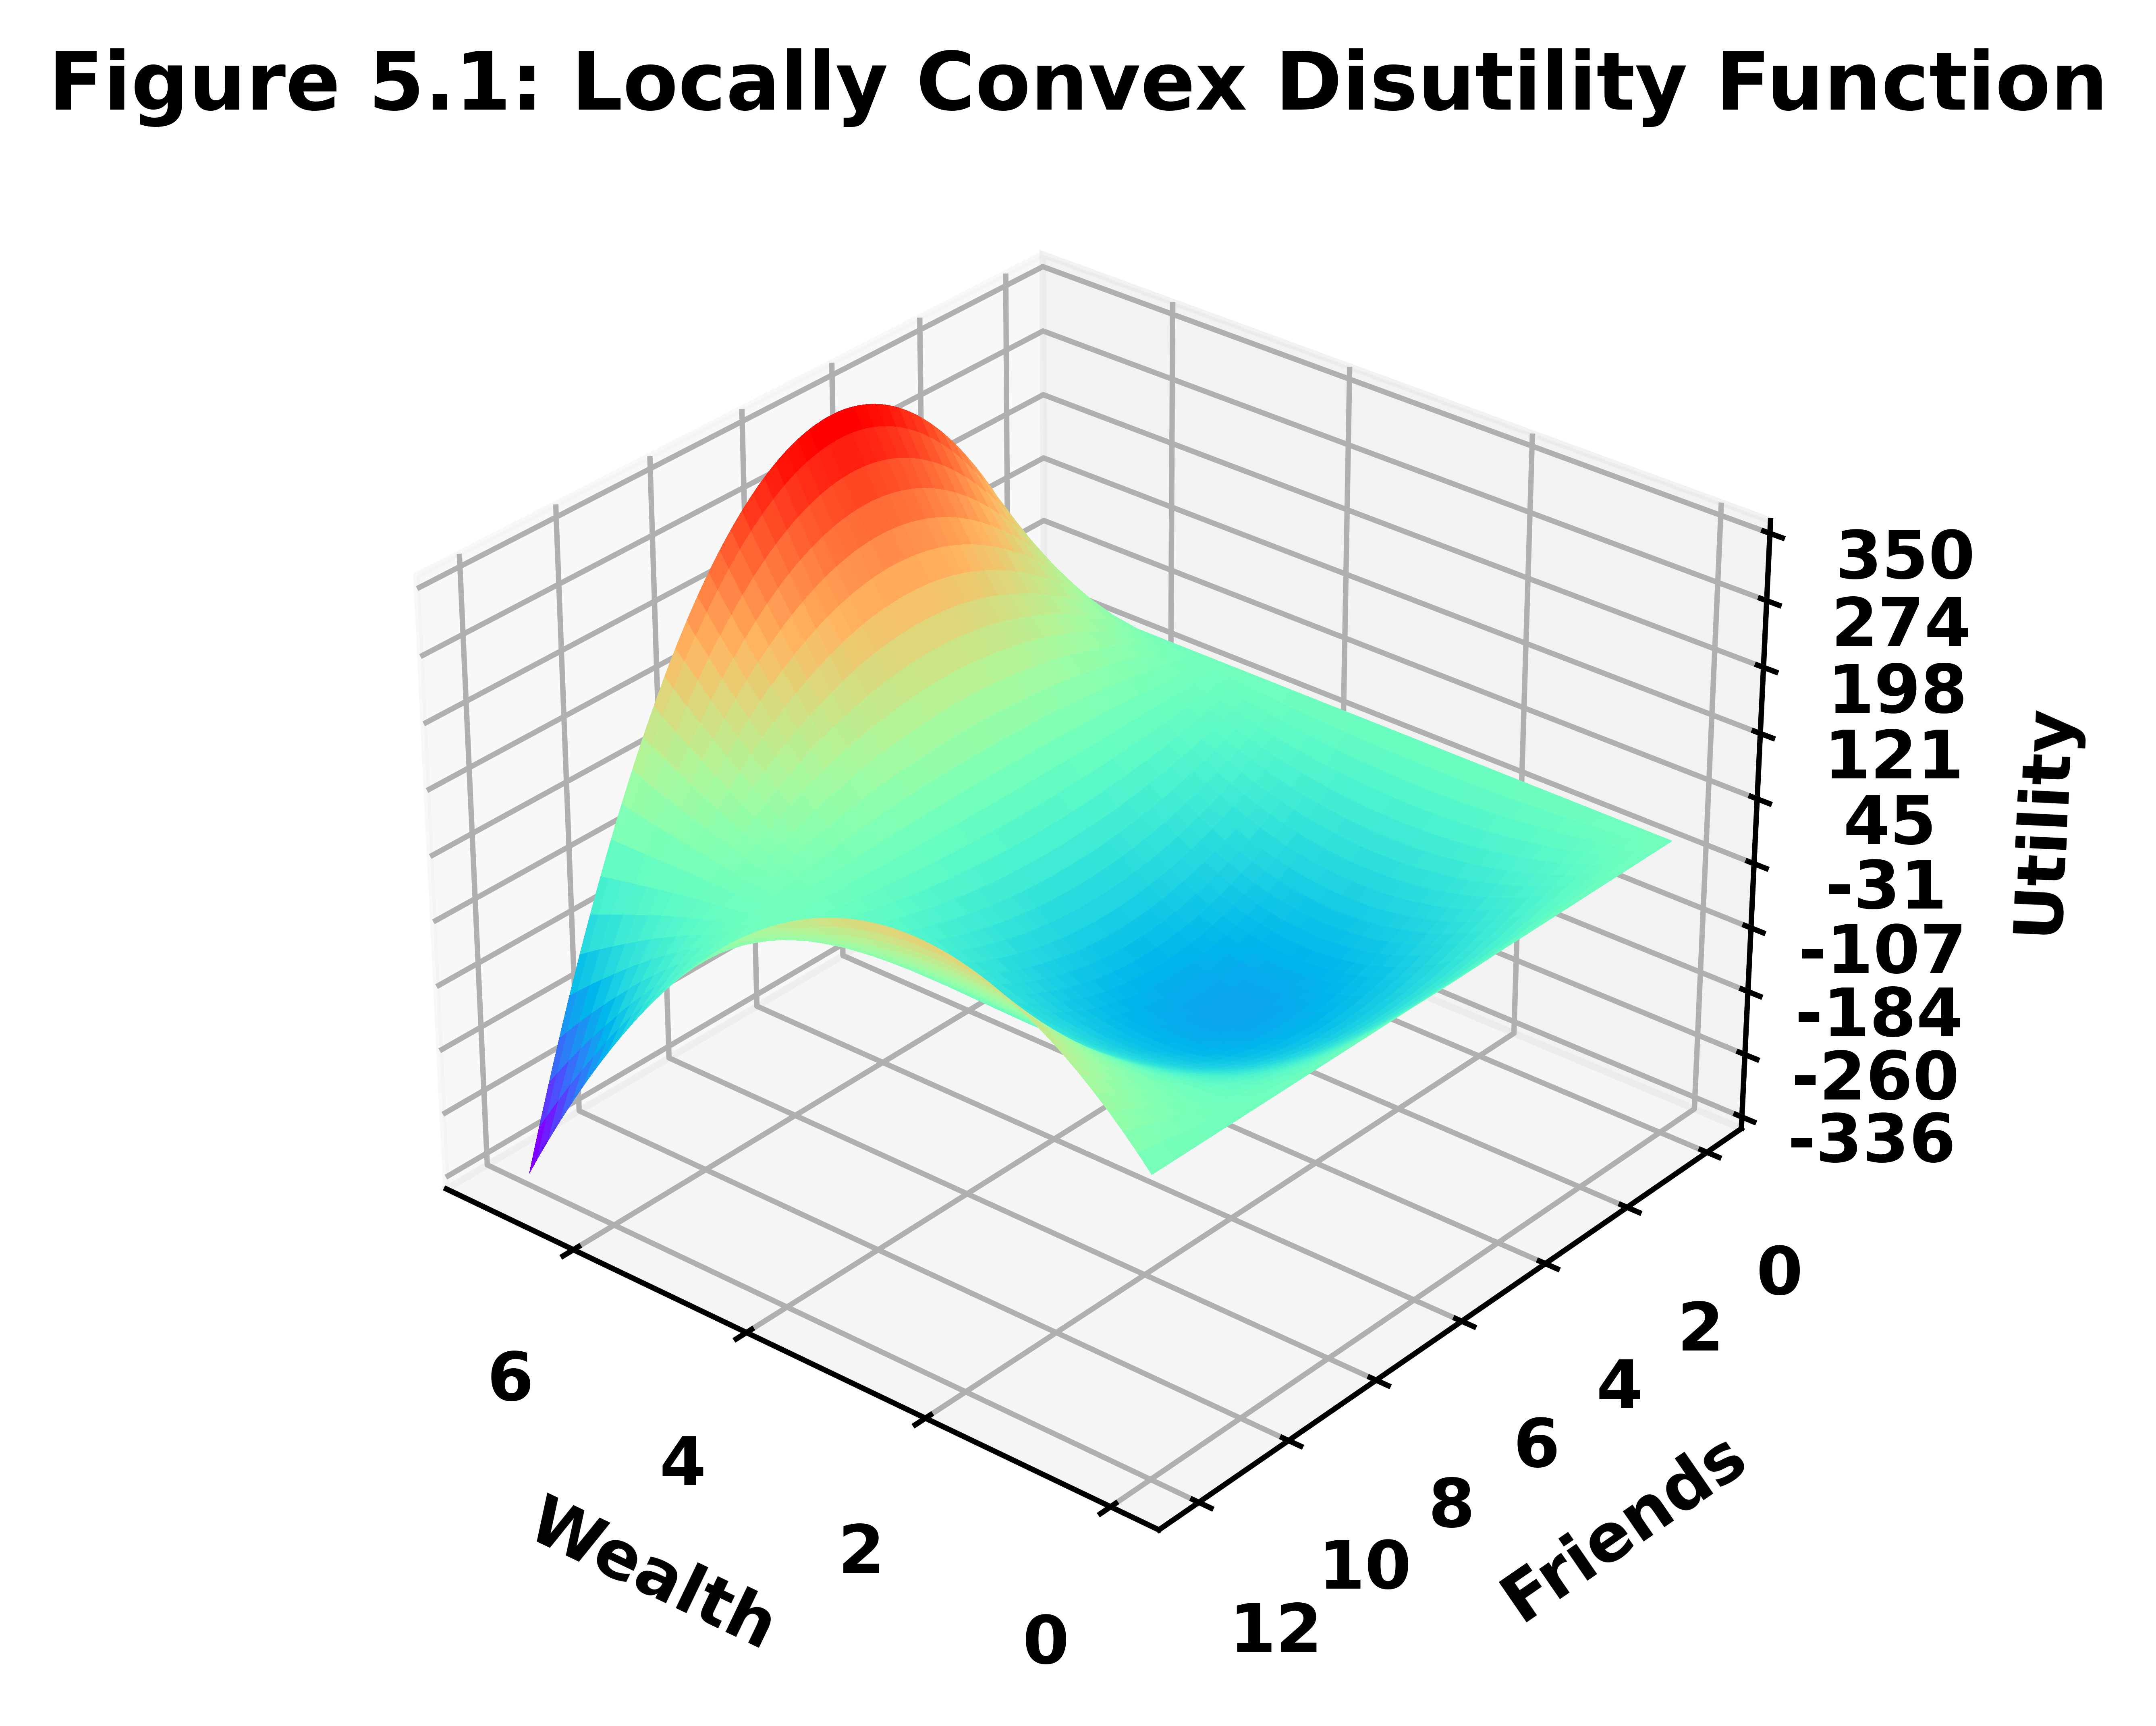

In [14]:
#Graph Idee's disutility function

import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as spst
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

#draw surface
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},dpi=1200)

# Make data.
X = np.arange(0.,7.05,.05)
Y = np.arange(0.,12.05,.05)
X, Y = np.meshgrid(X, Y)
Z = util([X,Y])

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.rainbow,
    linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.view_init(ax.elev, ax.azim-170)

#Label axes
ax.set_xlabel('Wealth')
ax.set_ylabel('Friends')
ax.set_zlabel('Utility')

s_title="Figure 5.1: Locally Convex Disutility Function"
plt.title(s_title)

plt.show();

The light blue well centered at wealth=$2.5$, friends=$5$ has the minimum value $-156.25$ as noted above. However the front left corner of the graph at wealth=$7$, friends=$12$ has a value of $-336$. If we extended the graph far enough in either direction, we would get arbitrarily large negative values. Because the function is not everywhere convex, the local minimum is not a global minimum.

## 5.3 Unconstrained Convex Optimization ##

The Idee Adymr example shows that functions that are not globally convex can have messy behavior. But even if the function to be minimized is known to be convex, the unconstrained minimization problem might not have a closed-form solution. (Unconstrained means that there are no $g$ or $h$ functions in the generic form \eqref{eq:generic_optimization}.) 

The necessary and sufficient condition for $x_M$ to be a global minimum of a convex function $f$ is that the gradient $\nabla f(x_M)=0$. But the gradient could be highly nonlinear and difficult to solve in closed form.

A simple example of a convex function is the portfolio mean-variance optimization problem from Chapter 4, or more generally a quadratic objective function
$$f(x)=-m^{\intercal}x+\frac{1}{2}x^{\intercal}Cx\label{eq:quadratic_objective}\tag{5.10}$$
Here the unknown $x$ is a portfolio vector, i.e. an $n$-vector of amounts of holdings in $n$ possible assets. $C$ is the $n\times n$ covariance matrix (which is symmetric by construction), and $m$ is the $n$-vector of mean (expected) returns. Property 5.4 indicates that the function $f$ is convex if and only if $C$ is positive semidefinite, which it must be by construction.

If $C$ is strictly positive definite &mdash; i.e. the function is strictly convex &mdash; then $C$ is nonsingular and critical point is simply $x_{min}=C^{-1}m$. 

However if $C$ is singular &mdash; positive semidefinite but not positive definite &mdash; then there may or may not be a solution to the matrix equation $C x_{min}=m$. For example if
$$
C =
  \left[ {\begin{array}{cc}
   1 & 0 \\
   0 & 0\\
  \end{array} } \right]
\quad\text{and}\quad
m =
  \left[ {\begin{array}{c}
   1 \\
   1 \\
  \end{array} } \right]
$$
then the objective function is $\frac{1}{2}v^2-v-w$ where $v$ and $w$ are the two scalar components of the argument vector $x$. The Hessian is positive semidefinite, but there is no solution to $Cx_{min}=m$ because every multiple of $C$ has a zero in the second component. In this case the second scalar component $w$ is unbounded and can go to $\infty$, giving an arbitrarily small objective function.

The Spectral Decomposition Theorem says that a positive semidefinite matrix can be written as $C=E_k D_k E_k^{\intercal}$, where $k\leq n$ and $E_k$ is the $n\times k$ matrix of eigenvectors of $C$ associated with nonzero eigenvalues; the $k<n$ nonzero eigenvalues are contained in the $k\times k$ diagonal matrix $D_k$. $E_k$ is standardized so that $E_k^{\intercal}E_k=I_k$ where $I_k$ is the $k\times k$ identity matrix.

>Property 5.5: For positive semidefinite C, there is a solution to $Cx_{min}=m$ if and only if $m$ is in the nullity of $I−E_kE_k^{\intercal}$ where the columns of $E_k$ are the standardized eigenvectors of $C$.

Proof: Recall that the nullity of a matrix $M$ is the set of vectors $x$ such that $Mx=0$.

Suppose first that there is a solution $x_{min}$ to $Cx_{min}=m$. Set $\lambda=D_kE_k^{\intercal}x_{min}$ where $D_k$ is the diagonal matrix of associated eigenvalues as above. $\lambda$ is a $k$-vector with the property $E_k\lambda=m$, so $E_k^{\intercal}E_k\lambda=E_k^{\intercal}m$, i.e. $\lambda=E_k^{\intercal}m$ since $E_k$ was standardized. Thus $E_k\lambda=E_k (E_k^{\intercal}m)$, i.e. $m=E_k (E_k^{\intercal}m)$ so $(I-E_kE_k^{\intercal})m=0$ proving the desired nullity holds.

In the other direction suppose that $(I-E_kE_k^{\intercal})m=0$, i.e. $m=E_kE_k^{\intercal}m$. Set $x_{min}=E_kD_k^{-1}E_k^{\intercal}m$. Then $Cx_{min}=E_kD_kE_k^{\intercal}E_kD_k^{-1}E_k^{\intercal}m=E_kE_k^{\intercal}m=m$ where the last equality follows by supposition. (End Property 5.5 proof.)

In the example above where
$$
C =
  \left[ {\begin{array}{cc}
   1 & 0 \\
   0 & 0\\
  \end{array} } \right]
\quad\text{and}\quad
m =
  \left[ {\begin{array}{c}
   1 \\
   1 \\
  \end{array} } \right]
$$
$k=1$ and $E_1=E_k=
\left[ {\begin{array}{c}
   1 \\
   0 \\
  \end{array} } \right]
$, so $I-E_kE_k^{\intercal}=
  \left[ {\begin{array}{cc}
   0 & 0 \\
   0 & 1\\
  \end{array} } \right]
$. Multiplying 
$  \left[ {\begin{array}{cc}
   0 & 0 \\
   0 & 1\\
  \end{array} } \right]
\left[ {\begin{array}{c}
   1 \\
   1 \\
  \end{array} } \right]
=
\left[ {\begin{array}{c}
   0 \\
   1 \\
  \end{array} } \right]
$ which is not zero, so $m$ is not in the nullity and Property 5.5 says there is no solution.

For the case where $m$ is in the nullity of $I−E_kE_k^{\intercal}$, a solution looks like
$$x_{min}=E_kD_k^{-1}E_k^{\intercal}m+Z_{n-k}\nu\label{eq:generalized_inverse}\tag{5.11}$$
where $\nu$ is any $(n-k)$-vector. Here $Z_{n-k}$ is the $n\times (n-k)$ matrix of eigenvectors associated with the zero eigenvalue of $C$. $E_kD_k^{-1}E_k^{\intercal}$ is the **`pseudo-inverse`** of $C$.

For example if
$$
C =
  \left[ {\begin{array}{cc}
   1 & 1 \\
   1 & 1\\
  \end{array} } \right]
\quad\text{and}\quad
m =
  \left[ {\begin{array}{c}
   1 \\
   1 \\
  \end{array} } \right]
$$
then $k=1$ and $E_k=
  \left[ {\begin{array}{c}
   1/\sqrt{2} \\
   1/\sqrt{2} \\
  \end{array} } \right]
$. The matrix $I-E_kE_k^{\intercal}=
\frac{1}{2}  \left[ {\begin{array}{cc}
   1 & -1 \\
   -1 & 1\\
  \end{array} } \right]
$
and $m$ is in its nullity, so there is a solution to $Cx_{min}=m$. In this example
$Z_1=
  \left[ {\begin{array}{c}
   1/\sqrt{2} \\
   -1/\sqrt{2} \\
  \end{array} } \right]
$. The nonzero eigenvalue is $D_1=2$. Thus the form of solutions in this case is
$$
x_{min}=
\frac{1}{2}
  \left[ {\begin{array}{c}
   1 \\
   1 \\
\end{array} } \right]
+\nu    \left[ {\begin{array}{c}
   1 \\
   -1 \\
  \end{array} } \right]
$$
where $\nu$ is an arbitrary scalar.

### 5.3.1 Gradient Descent ###

When the convex objective function $f$ is more complicated, an iterative technique can be applied. The nonoptimality of a point $x$ is $f(x)-f(x_{min})$; this must be non-negative. Under a condition called **`strong convexity`**, nonoptimality can be bounded both below and above:
$$\frac{1}{2e_{max}}\nabla f(x)^{\intercal}\nabla f(x)\leq f(x)-f(x_{min})
\leq \frac{1}{2e_{min}}\nabla f(x)^{\intercal}\nabla f(x)
\label{eq:bracket_minimum}\tag{5.12}$$
Here $x_{min}$ is the global minimum point, and $x$ is any other point. $e_{min}$ and $e_{max}$ are the minimum and maximum eigenvalues of the Hessian matrix over the domain of $f$.

Even when \eqref{eq:bracket_minimum} doesn't hold, it's reasonable to look at $\nabla f(x)^{\intercal}\nabla f(x)$ as an indicator of how close $x$ is to $x_{min}$: after all, when $x=x_{min}$ the gradient $\nabla f(x)$ equals zero. So a small dot product $\nabla f(x)^{\intercal}\nabla f(x)$ is a clue that $x$ is close to $x_{min}$. This idea is used in the **`Gradient Descent Method`**[$^3$](#five_footnotes), which proceeds as follows:

>Gradient Descent Method
>1. Choose an initial point $x_0$ and a convergence parameter $\epsilon$. Set $i=0$.
2. Evaluate $\nabla f(x_i)$, the gradient at $x_i$.
3. Check convergence $\nabla f(x_i)^{\intercal}\nabla f(x_i)<\epsilon$ for some target $\epsilon$. If converged, stop with $x_{min}=x_i$. Otherwise continue.
4. Choose a scalar step size $\delta_i$.
5. Set $x_{i+1}=x_i-\delta_i\nabla f(x_i)$ and $i=i+1$. Go back to step 2.

$\epsilon$ should be chosen so that the gradient is reasonably close to zero before convergence is declared.

The complexity of the objective function $f$ needs to be taken into account when choosing the scalar distance $\delta_i$ in step 4. If it's computationally easy to find the $\delta_i$ that minimizes $f(x_i-\delta_i\nabla f(x_i))$, then that's what should be done. For example, if the objective function is the quadratic one \eqref{eq:quadratic_objective}, then a closed-form expression for $\delta_i$ can be computed.

For more difficult objective functions, **`backtracking`** might need to be used. The idea is to take a big step, and then reduce the step size iteratively until it appears to be approximately optimal.

To visualize this, suppose you are walking through hilly countryside and want to find the lowest place of the terrain. You are completely fogged in so you can't see anything around you, but once you step on a point you can check your altimeter and see how high or low you are.

One strategy would be to take very tiny steps, exhaustively covering all the terrain. That would increase the chance that you find your way to the lowest point, but it might take a very long time. On the other hand, you could adopt a strategy of taking giant leaps for each step. That might speed things up, but it would increase the chance that you jump right over the minimum and never find it.

The backtracking method tries to combine the best of both worlds: take a big jump in some direction, and then cut back judiciously until you seem to be converging on the best you can do in that direction. To control the backtracking process, there are two search parameters: $0<\alpha<\frac{1}{2}$ and $0<\beta<1$. $\beta$ will be a fineness parameter: the closer it is to one, the finer the search. $\alpha$ controls the accuracy of the search in a different way: the closer $\alpha$ is to $\frac{1}{2}$, the more optimal the searched-for distance will be.

The backtracking algorithm chooses $\delta_i$ in step 4 of the Gradient Descent Method, assuming that the current point is $x_i$. To be more general, we'll just call these items $\delta$ and $x$ within the discussion of backtracking.

Given a proposed step direction $s$ &mdash; for Gradient Descent, $s=\nabla f(x)$ &mdash;  and a gradient $g$ &mdash; in this case, also $g=\nabla f(x)$ &mdash; the Backtracking Algorithm proceeds as follows:
>Backtracking Algorithm
> 1. Set $\delta = 1$.
2. Look at the proposed new objective function $f(x-\delta s)$. Is this larger than $f(x)-\alpha\delta g^{\intercal}s$? If not, stop and return the current $\delta$. If so, go to step 3.
3. Set $\delta=\beta\delta$ and go to step 2.

Why does the stopping test in step 2 work when $s=g=\nabla f(x)$? Assuming there is a maximum Hessian eigenvalue $e_{max}$ as above, we can alter \eqref{eq:mean_value_theorem} to say
$$f(y)\leq f(x)+(\nabla f(x))^{\intercal}(y-x)+\frac{e_{max}}{2}(y-x)^{\intercal}(y-x)
\label{eq:converge_criterion}\tag{5.13}$$

So if $y=x-\delta\nabla f(x)$, we can write
$$f(x-\delta\nabla f(x))\leq f(x) + \delta\bigl(\frac{\delta e_{max}}{2}-1\bigr)(\nabla f(x))^{\intercal}\nabla f(x)\label{eq:emax_bound}\tag{5.14}$$
Note that $\frac{\delta e_{max}}{2}-1<-\frac{1}{2}$
when $0\leq \delta \leq \frac{1}{e_{max}}$, so for small positive $\delta$, we have
$$f(x-\delta\nabla f(x))\leq f(x) -\frac{\delta}{2}(\nabla f(x))^{\intercal}\nabla f(x)
\leq f(x)-\alpha\delta(\nabla f(x))^{\intercal}\nabla f(x)
\label{eq:alpha_bound}\tag{5.15}$$
where the second inequality holds because $\alpha<\frac{1}{2}$.

\eqref{eq:alpha_bound} shows that the condition for the backtracking algorithm will be satisfied for small enough $\delta$. The efficiency of the algorithm depends on how many steps it takes to find a good descent size $\delta$.

As an example, consider the objective function
$$f(x)=ln\biggl(
\sum_{i=1}^3 exp(a_i^{\intercal}x+b_i)
\biggr)
$$
where $x$ is a $2$-vector and
$$
a_1=
  \left[ {\begin{array}{c}
   1 \\
   3 \\
  \end{array} } \right]
, a_2=
  \left[ {\begin{array}{c}
   1 \\
   -3 \\
  \end{array} } \right]
, a_3=
\left[ {\begin{array}{c}
   -1 \\
   0 \\
  \end{array} } \right]
, b_1=b_2=b_3=-.1$$

We'll start with the initial point
$x_0=
\left[ {\begin{array}{c}
   1 \\
   1 \\
  \end{array} } \right]
$
We used $\alpha=.25$ and $\beta=.75$. The code in the next cell performs gradient descent:

In [15]:
#Gradient descent method for log(sum(exp(ai'x+bi))) objective function

#Problem parameters
n=2; m=3   #variables, components of sum
a=np.zeros((m,n))
a[0]=[1,3]
a[1]=[1,-3]
a[2]=[-1,0]
b=[-.1,-.1,-.1]
def objfunc(x):
    #This objective function is reasonably scaled so not using order_magnitude adjustment
    sumexps=sum([np.exp(np.matmul(a[i],x)+b[i]) for i in range(m)])
    return(np.log(sumexps))

#gradient of this objective function
def gradfunc(x):
    gradvec=np.zeros(n)
    sumexps=0.
    for i in range(m):
        this_exp=np.exp(np.matmul(a[i],x)+b[i])
        gradvec+=this_exp*a[i]
        sumexps+=this_exp
    return(gradvec/sumexps)

def gradientmethod(xinit,objfunc,gradfunc,talkative):
    global order_magnitude    #variable used to size objective function around 1
#Gradient descent method
    #Starting point
    x=xinit
    iteration=0
    #initialize order of magnitude - objfunc uses this to scale objective
    order_magnitude=0.
    
    if talkative:
        print("Initial point:",x[0])
        print("Objective function at initial point:",objfunc(x[0]))
        print("Gradient at initial point:",gradfunc(x[0]))
    
    #Parameters for backtracking
    alpha=.25
    beta=.75
    epsilon=10**(-8)
    maxiter=500

    #Iterate as long as necessary
    while True:
        deltax=-gradfunc(x[iteration])
        delta=1

        #Backtracking
        current_obj=objfunc(x[iteration])
        grad_squared=np.matmul(deltax,deltax)
        if talkative: print(iteration," obj:",current_obj, \
                " grad^2:",grad_squared)
        if grad_squared < epsilon:
            break     #Done

        while True:
            y=x[iteration]+delta*deltax
            new_obj=objfunc(y)
            if new_obj > current_obj-delta*alpha*grad_squared:
                delta*=beta
            else:
                break   #Backtracking done

        if talkative: print("Delta from backtracking:",delta)
        x.append(y)
        iteration+=1
        if iteration > maxiter:
            break
    return(x)

#Starting point
xinit=[[1]*n]
x=gradientmethod(xinit,objfunc,gradfunc,True)

print("optimal x",x[-1])
print("optimal objective",objfunc(x[-1]))
print("gradient",gradfunc(x[-1]))

Initial point: [1, 1]
Objective function at initial point: 3.9091744845917344
Gradient at initial point: [0.98664717 2.96523407]
0  obj: 3.9091744845917344  grad^2: 9.766085755759542
Delta from backtracking: 0.5625
1  obj: 2.4198033815320383  grad^2: 8.332277507974275
Delta from backtracking: 0.31640625
2  obj: 1.191342005793633  grad^2: 1.8085316901136013
Delta from backtracking: 0.2373046875
3  obj: 1.0371266525499625  grad^2: 0.4614786912439451
Delta from backtracking: 0.31640625
4  obj: 0.993811097175349  grad^2: 0.3000411969185905
Delta from backtracking: 0.31640625
5  obj: 0.9663931514449048  grad^2: 0.15240881861624558
Delta from backtracking: 0.31640625
6  obj: 0.9513765394485699  grad^2: 0.06234346749137597
Delta from backtracking: 0.31640625
7  obj: 0.9444446348940022  grad^2: 0.021872767145336654
Delta from backtracking: 0.31640625
8  obj: 0.9416102287070496  grad^2: 0.0071421499562395055
Delta from backtracking: 0.421875
9  obj: 0.9406337475243942  grad^2: 0.005013547563411

The output shows that $f(x_0)=3.909$ and
$$\nabla f(x_0)=
\left[ {\begin{array}{c}
   .987 \\
   2.965 \\
  \end{array} } \right]
$$
The algorithm converged in 24 iterations to a solution $x_{min}=[-.3465,0]^{\intercal}$ and an objective function $f(x_{min})=.9397$. The backtracking algorithm generally chose $\delta$ between $.3$ and $.43$.

### 5.3.2 Newton's Method ###

Newton's Method is an iterative technique like the gradient descent method, but one that often has faster convergence properties.

Consider a step from $x$ to $y$ as follows:
$$y=x-\delta \bigl(\nabla^2 f(x)\bigr)^{-1}\nabla f(x)$$
The gradient step used in the gradient descent method has been modified by left-multiplying by the inverse of the Hessian matrix, which must be strictly positive definite for this approach to work. The idea is to take advantage of the Taylor expansion:
$$f(y)=f(x)+(\nabla f(x))^{\intercal}(y-x)
+\frac{1}{2}(y-x)^{\intercal}\nabla^2 f(x) (y-x)+\dots$$
Substituting $y=x-\delta \bigl(\nabla^2 f(x)\bigr)^{-1}\nabla f(x)$ into the Taylor expansion gives
$$f\bigl(x-\delta \bigl(\nabla^2 f(x)\bigr)^{-1}\nabla f(x)\bigr)=f(x)-\bigl(\delta-\frac{\delta^2}{2}\bigr)(\nabla f(x))^{\intercal} \bigl(\nabla^2 f(x)\bigr)^{-1}\nabla f(x)+O(\delta^3)$$
This shows that for small enough $\delta$ and a strictly positive definite Hessian, the step from $x$ to $y$ is guaranteed to be a descent.

The algorithm is straightforward:
>Newton's Method Algorithm
>1. Pick an initial $x_0$ and set $i=1$. Choose a tolerance parameter $\epsilon$ and backtracking algorithm parameters $\alpha$ and $\beta$.
2. Evaluate the quadratic form $(\nabla f(x_{i-1}))^{\intercal}(\nabla^2 f(x_{i-1}))^{-1}(\nabla f(x_{i-1}))$. If this is less than the tolerance parameter $\epsilon$, quit and return the result $x_{i-1}$.
3. Choose a step size $\delta_i$ using the backtracking algorithm with step $s=(\nabla^2 f(x_{i-1}))^{-1}\nabla f(x_{i-1})$ and gradient $g=\nabla f(x_{i-1})$.
4. Move to $x_i=x_{i-1}-\delta s$, increment $i$, and go back to step 2.

The next code segment re-solves the example problem that was used above for the gradient descent method, this time with Newton's Method:

In [16]:
# Use Newton's method to optimize the previous function

def hessfunc(x,epsilon):
    #Hessian function computed by differencing gradient
    hessmatrix=np.zeros((n,n))
    for i in range(n):
        deltai=np.zeros(n)
        deltai[i]=epsilon
        xx=np.array(x)
        hessmatrix[i]=(gradfunc(xx+deltai)-gradfunc(xx))/epsilon
    return(hessmatrix)

def newtonmethod(xinit,objfunc,gradfunc,hessfunc):
    global order_magnitude    #variable used to size objective function around 1

#Run Newton's Method with calls to objfunc, gradfunc, and hessfunc
    #Starting point
    x=xinit
    print(x[0])
    iteration=0
    #initialize order of magnitude - objfunc uses this to scale objective
    order_magnitude=0.

    #Parameters for backtracking
    alpha=.25
    beta=.75
    epsilon=10**(-8)
    maxiter=500

    print("Objective function at initial point:",objfunc(x[0]))
    print("Gradient at initial point:",gradfunc(x[0]))
    print("Hessian at initial point:",hessfunc(x[0],epsilon))
    print("Inverse Hessian initial:",np.linalg.inv(hessfunc(x[0],epsilon)))

    #Iterate as long as necessary
    while True:
        deltax=-np.matmul(np.linalg.inv(hessfunc(x[iteration],epsilon)), \
                          gradfunc(x[iteration]))
        delta=1

        #Backtracking
        current_obj=objfunc(x[iteration])
        grad_hessinv_grad=np.matmul(gradfunc(x[iteration]),deltax)
        print(iteration," obj:",current_obj, \
              " grad_hessinv_grad:",-grad_hessinv_grad)
        if -grad_hessinv_grad < epsilon:
            break     #Done

        while True:
            y=x[iteration]+delta*deltax
            new_obj=objfunc(y)
            if new_obj > current_obj+delta*alpha*grad_hessinv_grad:
                delta*=beta
            else:
                break   #Backtracking done

        y=x[iteration]+delta*deltax
        print(delta,y)
        x.append(y)
        iteration+=1
        if iteration > maxiter:
            break
    #x has the x vector for each iteration, with the last one
    #being the optimal (or last if ran out of iterations)
    return(x) 
            
xinit=[[1]*n]
x=newtonmethod(xinit,objfunc,gradfunc,hessfunc)
    
print("optimal x:",x[-1])
print("iterations:",len(x)-1)
print("optimal objective:",objfunc(x[-1]))
print("gradient:",gradfunc(x[-1]))
print("Hessian",hessfunc(x[-1],10**(-8)))


[1, 1]
Objective function at initial point: 3.9091744845917344
Gradient at initial point: [0.98664717 2.96523407]
Hessian at initial point: [[0.02652737 0.03959433]
 [0.03959425 0.14729915]]
Inverse Hessian initial: [[ 62.95504778 -16.92245195]
 [-16.92241874  11.33768788]]
0  obj: 3.9091744845917344  grad_hessinv_grad: 61.9550186818811
0.1001129150390625 [-0.19488658 -0.69415497]
1  obj: 1.9695284290060509  grad_hessinv_grad: 5.531911655234065
0.2373046875 [0.58173321 0.05768105]
2  obj: 1.332917842911155  grad_hessinv_grad: 1.1717248760683536
0.75 [-0.60126449  0.03222069]
3  obj: 0.9735631248857185  grad_hessinv_grad: 0.07127301938153104
1 [-0.33182959 -0.01084381]
4  obj: 0.9400979212470573  grad_hessinv_grad: 0.0007467797214999371
1 [-3.46318864e-01 -1.52792099e-04]
5  obj: 0.9397208558231811  grad_hessinv_grad: 1.6993978123362368e-07
1 [-3.46573538e-01 -3.88955953e-08]
6  obj: 0.9397207708399228  grad_hessinv_grad: 9.563096791675888e-15
optimal x: [-3.46573538e-01 -3.88955953e-08

Newton's Method arrives at the same answer as gradient descent, but after only 6 iterations. Each iteration is more computationally costly than gradient descent as a matrix inversion and matrix multiplications are performed. However overall efficiency is probably better.

There are many variants of descent algorithms, and a number of tuning techniques that can speed unconstrained optimization considerably when there are large numbers of variables. Most scientific computation packages have large numbers of sophisticated methods to solve minimization problems. For example, the following code segment solves the example problem yet again using scipy.optimize's Conjugate Gradient (CG) method:

In [17]:
# Use built-in scipy.optimize function to minimize
# the previous function

#initial guess for parameters
init_params=[1.]*n
#Run the minimization.
results = scpo.minimize(objfunc,
                            init_params, jac=gradfunc, 
                            method='CG')
print(results.x)
print(objfunc(results.x),gradfunc(results.x))

[-3.46579585e-01 -1.16131017e-07]
0.9397207708579167 [-5.99472090e-06 -5.22586444e-07]


## 5.4 Constrained Optimization ##

In most practical applications, the objective function $f:\mathbb{R}^n\to\mathbb{R}$ is not allowed to operate on the entirety of $n$-space.

For example, when we considered the simple portfolio optimization example \eqref{eq:quadratic_objective}, we didn't take into account the tautology that $100\%$ of a portfolio is all we have to invest, i.e. the budget constraint $x^{\intercal}u=1$ where $u$ is the vector of all ones.

More generally, an equality-constrained convex optimization problem looks like
$$\text{minimize}_{x} f(x)$$
$$\text{subject to }Ax=b\label{eq:equality_constrained}\tag{5.20}$$
Here $A$ is a $k\times n$ matrix with $k\leq n$ and $b$ is a $k$-vector. Recall that the generic optimization problem's equality constraints in \eqref{generic_optimization} were expressed as components of the vector identity $g(x)=0$. Here the function $g(x)=Ax-b$ is linear because of the convexity requirement. An equality constraint is the same as two inequality constraints, $g_i(x)\geq 0$ and $-g_i(x)\geq 0$; the only way both can be true and $g_i(x)$ can be convex is for $g_i(x)$ to be linear.

The feasible set for problem \eqref{eq:equality_constrained} is the set $F=\{x|Ax=b\}$. Recall from standard calculus that problems like \eqref{eq:equality_constrained} can be solved with **`Lagrange Multipliers`**. Joseph-Louis Lagrange noticed that if $x_{min}\in F$ and minimizes $f$ among all members of $F$, then there exists a $k$-vector $\lambda$ so that
$$\nabla f(x_{min})=A^{\intercal}\lambda\label{eq:basic_lagrange}\tag{5.21}$$

In effect the Lagrange multipliers &mdash; the components of the $\lambda$ vector &mdash; extend the function $f$ on $n$ variables to a function $h$ on $n+k$ variables:
$$h(x_1,\dots,x_n,\lambda_1,\dots,\lambda_k)=f(x_1,\dots,x_n)-\lambda^\intercal (Ax-b)=f(x_1,\dots,x_n)-
\sum_{j=1}^k \lambda_j (a_jx-b_j)\label{eq:lagrange_extended}\tag{5.22}$$

where $a_j$ is the $1\times k$ vector giving the $j^{th}$ row of $A$. The function $h$ is called the **`Lagrangian`** of the problem \eqref{eq:equality_constrained}. The partial derivative of $h$ with respect to $\lambda_j$ encodes the $j^{th}$ equality constraint.

Thus unconstrained optimization techniques can be used on the function $h(x_1,\dots,x_n,\lambda_1,\dots,\lambda_k)$. The resulting $x^{*}=(x_1,\dots,x_n)$ will be the optimal vector that satisfies the equality constraints.

For example, suppose there are linear equality constraints with a portfolio optimization problem like \eqref{eq:quadratic_objective}:
$$\text{minimize}_{x} -m^{\intercal}x+\frac{1}{2}x^{\intercal}Cx$$
$$\text{subject to }Ax=b\label{eq:equality_constrained_example}\tag{5.23}$$
where $A$ is a $k\times n$ matrix and $b$ is a $k$-vector.

The Lagrangian is
$$-m^{\intercal}x+\frac{1}{2}x^{\intercal}Cx+\lambda^{\intercal}(Ax-b)$$
where $\lambda$ is a $k$-vector. Taking the gradient with respect to the extended $(x,\lambda)$ vector gives
$$Cx+A^{\intercal}\lambda=m$$
$$Ax=b$$

Define an $(n+k)\times (n+k)$ matrix
$$B=
  \left[ {\begin{array}{cc}
   C & A^{\intercal} \\
   A & 0\\
  \end{array} } \right]
$$
Then the optimization is just the solution to the linear system
$$B
  \left[ {\begin{array}{c}
   x \\
   \lambda \\
  \end{array} } \right]
=
  \left[ {\begin{array}{c}
   m \\
   b \\
  \end{array} } \right]
$$
If $B$ is nonsingular then the solution is simply
$  \left[ {\begin{array}{c}
   x \\
   \lambda \\
  \end{array} } \right]
=
B^{-1}
  \left[ {\begin{array}{c}
   m \\
   b \\
  \end{array} } \right]
$. Otherwise (if $B$ is singular), then the linear dependencies might need to be separated out using a pseudo-inverse as in \eqref{eq:generalized_inverse}.

For more complex problems than \eqref{eq:equality_constrained_example} where the objective function is not amenable to closed-form solution, an iterative method can be used to find the zero gradient of the Lagrangian \eqref{eq:lagrange_extended}.

An explicit way to require feasibility $Ax=b$ is to find the nullity of $A$, i.e. the $n \times (n-k)$ matrix $N$ such that $AN=0$. (We're assuming that $rank(A)=rowdim(A)=k$. If not, $N$ has more columns.)

The nullity $N$ of $A$ can be found from an eigendecomposition of $A^{\intercal}A$, which is an $n \times n$ matrix of rank $k$ assuming full row rank of $A$. The nullity of $A^{\intercal}A$ is made up of the $n-k$ eigenvectors of $A^{\intercal}A$ corresponding to zero eigenvalues. These are also in the null space of A since $A^{\intercal}Ax=0$ must mean $Ax=0$ or else $A$ is not of full row rank. So $A$'s nullity $N$ is the $n \times (n-k)$ matrix whose columns are the zero-eigenvalue eigenvectors of $A^{\intercal}A$.

Set $x_0=A^{\intercal}(AA^{\intercal})^{-1}b$; $x_0$ is a solution to $Ax_0=b$. Thus all solutions to $Ax=b$ can be written as $x=x_0+Nz$, where $z$ is any (i.e. unconstrained) $(n-k)$-vector.

Because of this, we can rewrite \eqref{eq:equality_constrained} as the unconstrained problem
$$\text{minimize}_{z} \text{ff}(z)\label{eq:constrained_unconstrained}\tag{5.25}$$
where $\text{ff}(z)=f(x_0+Nz)$. \eqref{eq:constrained_unconstrained} can be solved with an unconstrained technique like Newton's Method on a lower-dimensional (i.e. the size of $z$) problem.

A simple example of constraint mapping is a way to enforce a budget constraint $x^{\intercal}u=1$; simply define the last component $x_n$ of the $n$-vector $x$ as $x_n=1-x_1-\dots-x_{n-1}$. Plug this equality into the objective function and the other constraints, reducing the problem to one on $n-1$ variables where the budget constraint is built in.

### 5.4.1 Lagrange Duality ###

Even more generally than \eqref{equality_constrained}, an optimization problem can be written like this to include inequality constraints:
$$\text{minimize}_{x} f(x)$$
$$\text{subject to }g_i(x)\leq 0,\quad i=1,\dots,k\label{eq:inequality_constrained}\tag{5.30}$$
We won't require that $f(x)$ or $g_i(x)$ are convex for the remainder of this subsection 5.4.1.

A common technique in optimization is to look for a dual problem: that is, a problem that ends up being equivalent to the original under certain conditions. To this end, define the **`Lagrange dual function`** of the optimization \eqref{eq:inequality_constrained} as
$$L(\lambda)=\inf_{x\in F}\bigl\{
f(x)+\sum_{i=1}^k \lambda_i g_i(x)
\bigr\}\label{eq:lagrange_dual}\tag{5.31}$$
Here $F$ is the feasible set, $F=\{x|g_i(x)\leq 0,\quad i=1,\dots,k\}$

Let $M$ be the global minimum feasible point, i.e. $M\in F$ and $f(M)\leq f(x)$ for all $x\in F$. In other words, $M$ is a solution to the optimization problem \eqref{eq:inequality_constrained}.

If $x$ is feasible, $\sum_{i=1}^k \lambda_i g_i\leq 0$ when each $\lambda_i\geq0$, since feasibility means $g_i(x)\leq0$. Since $M$ is one of the feasible points over which the $inf$ in \eqref{eq:lagrange_dual} is taken, $L(\lambda)\leq f(M)$ must hold as long as each element of $\lambda$ is non-negative. 

The best lower bound that the Lagrange dual function can give can be found by constructing another optimization:

$$\text{minimize}_{\lambda} -L(\lambda)$$
$$\text{subject to }-\lambda_i\leq 0,\quad i=1,\dots,k
\label{eq:lagrange_dual_opt}\tag{5.33}$$

Note that
$$-L(a \lambda_1+(1-a)\lambda_2)=
-\inf_{x\in F}\bigl\{
f(x)+\sum_{i=1}^k \bigl(a\lambda_{1i}+(1-a)\lambda_{2i}\bigr)g_i(x)
\bigr\}$$
$$=-\inf_{x\in F}\bigl\{
a\biggl(f(x)+\sum_{i=1}^k \lambda_{1i}g_i(x)\biggr)
+(1-a)\biggl(f(x)+\sum_{i=1}^k \lambda_{2i}g_i(x)\biggr)
\bigr\}
$$
$$\leq -a\cdot \inf_{x\in F}\biggl\{
\biggl(f(x)+\sum_{i=1}^k \lambda_{1i}g_i(x)\biggr)
\biggr\}
-(1-a)\inf_{x\in F}\biggl\{
\biggl(f(x)+\sum_{i=1}^k \lambda_{2i}g_i(x)\biggr)
\biggr\}
$$
$$=-aL(\lambda_1)-(1-a)L(\lambda_2)$$

The inequality follows because allowing inf to work separately on each term allows it to (possibly) find a smaller value, which becomes larger when negated. This proves that the negative of the Lagrange dual function $-L(\lambda)$ is convex no matter what properties the original optimization \eqref{eq:inequality_constrainted} had.

Thus \eqref{eq:lagrange_dual_opt} is a convex optimization. Let $\lambda_M$ be a vector that minimizes $-L(\lambda_M)$ while satisfying the constraint of having all non-negative entries. Recall that $L(\lambda_M)\leq f(M)$. When equality holds, i.e. $L(\lambda_M)=f(M)$, the optimizations \eqref{eq:inequality_constrained} and \eqref{eq:lagrange_dual_opt} are said to have **`strong duality`**.

If strong duality holds, then
$$f(M)=L(\lambda_M)=
\inf_{x\in F}\biggl\{f(x)+\sum_{i=1}^k \lambda_{Mi}g_i(x)\biggr\}$$
$$\leq f(M)+\sum_{i=1}^k \lambda_{Mi}g_i(M)\leq f(M)
\label{eq:strong_duality}\tag{5.35}
$$
The first inequality in this series holds because the infimum of an expression over all feasible $x$ has to be less than or equal to the value of the expression at a particular feasible $x$, namely $x=M$. The second inequality holds because $M$ is feasible (so $g_i(M)\leq0$ as required in \eqref{eq:inequality_constrained}), and the $\lambda_{Mi}$ are non-negative as required in \eqref{eq:lagrange_dual_opt}. 

Thus $\lambda_{Mi}g_i(M)\leq 0$ for all $i$, so $\sum_{i=1}^k \lambda_{Mi}g_i(M)\leq 0$. In that case the inequalities in \eqref{eq:strong_duality} are actually equalities, so when strong duality holds then:
$$\sum_{i=1}^k \lambda_{Mi}g_i(M)= 0\label{eq:lagrange_zero_strong}\tag{5.36}$$

If every summand of the sum in \eqref{eq:lagrange_zero_strong} is non-positive and the sum is zero, then (under strong duality) every summand must be zero: $\lambda_{Mi}g_i(M)=0\enspace \forall i$. Thus under strong duality, a non-zero Lagrange multiplier $\lambda_{Mi}>0$ forces $g_i(M)=0$.

Define a Lagrangian function similar to \eqref{eq:lagrange_extended}:
$$h(x,\lambda)=f(x)+\sum_{i=1}^k \lambda_i g_i(x)\label{eq:dual_h_extended}\tag{5.37}$$
Then under strong duality
$$\inf_{x\in F}\{h(x,\lambda_M)\}=h(M,\lambda_M)$$
In other words, under strong duality a \eqref{eq:inequality_constrained} global minimum point $M$ also minimizes the Lagrangian. Minima are critical points as we noted in the paragraph containing \eqref{eq:critical_limit}, so
$$\nabla_x h(M,\lambda_M)=\nabla f(M)+\sum_{i=1}^k \lambda_{Mi} \nabla g_i(M) = 0
\label{eq:critical_lagrange}\tag{5.38}$$

\eqref{eq:critical_lagrange} is a stronger version of Lagrange's \eqref{eq:basic_lagrange}.

Thus under strong duality between \eqref{eq:inequality_constrained} and \eqref{eq:lagrange_dual_opt}, the following conditions hold on a global minimum point $M$ and the dual optimal Lagrange vector $\lambda_M$. These are called the **`Karush-Kuhn-Tucker ("KKT")`** conditions:[$^4$](#five_footnotes)
>$$\text{Karush-Kuhn-Tucker Conditions}\label{eq:kkt_basic}\tag{5.40}$$
> $$g_i(M)\leq 0$$
$$\lambda_{Mi}\geq 0\text{ for all }i$$
$$\lambda_{Mi} g_i(M)=0\text{ for all }i$$
$$\nabla f(M)+\sum_{i=1}^k \lambda_{Mi}\nabla g_i(M)=0$$

Strong duality implies KKT \eqref{eq:kkt_basic}.

### 5.4.2 KKT Conditions With Convexity ###

But.... it is not generally true that KKT implies strong duality. Some conclusions can be made in the other direction if the original optimization problem \eqref{eq:inequality_constraints} is convex. While the previous subsection 5.4.1 was general and didn't require convexity, for the remainder of this subsection 5.4.2 we'll assume that both the objective function $f(x)$ and all the constraint functions $g_i(x)$ are convex.

In that case, note that any equality constraints (where both $g_i(x)\geq 0$ and $-g_i(x)\geq 0$ must be affine (linear), since the only way a function and its opposite can both be convex is if the function is affine.

Assume that there is a $y$ and a $\lambda$ such that the KKT conditions hold:
>$$\text{KKT Conditions with inputs}\label{eq:kkt_inputs}\tag{5.41}$$
>$$g_i(y)\leq 0$$
$$\lambda_i\geq 0\text{ for all }i$$
$$\lambda_i g_i(y)=0\text{ for all }i$$
$$\nabla f(y)+\sum_{i=1}^k \lambda_i \nabla g_i(y)=0$$

The first two lines of \eqref{eq:kkt_inputs} mean that $y$ is feasible for \eqref{eq:inequality_constrained} and that $\lambda$ is feasible for the dual problem \eqref{eq:lagrange_dual_opt}.

If the primary optimization \eqref{eq:inequality_constrained} is convex, then the Lagrangian function $h(y,\lambda)$ defined in \eqref{eq:dual_h_extended} is a linear combination of convex functions, so it is convex. The last line of \eqref{eq:kkt_inputs} says that the gradient with respect to $y$ of the Lagrangian is zero. With the assumption of convexity, Property 5.3 can be applied, implying that $y$ minimizes the Lagrangian. 

Together with definition \eqref{eq:lagrange_dual}, this shows that
$$L(\lambda)=\inf_{x\in F}\bigl\{
f(x)+\sum_{i=1}^k \lambda_i g_i(x)
\bigr\}
=h(y,\lambda)=
f(y)+\sum_{i=1}^k \lambda_i g_i(y)
\label{eq:inf_at_y}\tag{5.42}$$

The third line of \eqref{eq:kkt_inputs} implies $\sum_{i=1}^k \lambda_i g_i(x)=0$, so \eqref{eq:inf_at_y} says $L(\lambda)=f(y)$ and strong duality holds.

Another technical condition (that there is at least one feasible point of \eqref{eq:inequality_constrained} where the inequality constraints hold strictly) is needed to establish that $y$ is a global minimum.

A convex optimization problem like \eqref{eq:inequality_constrained} can be approached by finding points that satisfy the KKT conditions \eqref{eq:kkt_inputs}. That's often easier than trying to do the optimization with an iterative method.

The third KKT condition $\lambda_i g_i(y)=0\text{ for all }i$ separates the conditions of \eqref{eq:inequality_constrained} into two parts: strict inequality conditions where $g_i(y)<0$; and equality conditions where $g_i(y)=0$. For the former, $\lambda_i=0$ must hold. For the latter, the only information from the third KKT condition is that $\lambda_i\geq 0$ so more work is needed to determine these equality-constraint $\lambda_i$. 

When the problem and its constraints are convex, the only way to require equality (rather than having it possible but not required) is to have the single affine requirement $a_i^{\intercal}y-b_i=0$. Thus for convex problems, \eqref{eq:inequality_constrained} can be rewritten as
$$\text{minimize}_{x} f(x)$$
$$\text{subject to }g_i(x)\leq 0,\quad i=1,\dots,k_{ineq}$$
$$\text{and }Ax=b, \text{rowdim}(A)=\text{rowdim}(b)=k_{eq}$$
$$\text{f, g convex}
\label{eq:convex_constrained}\tag{5.45}$$

The KKT conditions for this form of the convex optimization problem are
>$$\text{KKT Conditions for \eqref{eq:convex_constrained}}\label{eq:kkt_convex}\tag{5.49}$$
>$$g_i(M)\leq 0\quad i=1,\dots,k_{ineq}$$
$$\lambda_{Mi}=0\text{ when }g_i(M)<0$$
$$\lambda_{Mi}\geq 0\text{ when }g_i(M)=0$$
$$Ax=b$$
$$\nabla f(M)+\sum_{\lambda_{Mi}\neq 0}
\lambda_{Mi} \nabla g_i(M)+A^{\intercal}\gamma=0$$

Here $\gamma$ is an unconstrained $k_{eq}$-vector. Note that even though inequality constraints don't <u>require</u> equality, equality may happen to hold at a solution. Thus it can't be assumed that the $\lambda_M$ associated with the $i^{th}$ inequality constraint is zero.

## 5.5 Barrier Methods ##

\eqref{eq:constrained_unconstrained} showed that an equality-constrained optimization could be reduced to an unconstrained optimization by using the Lagrangian \eqref{eq:lagrange_extended}. That then allowed iterative methods to be used to solve difficult problems.

Similarly, an inequality-constrained optimization can be reduced to a series of equality-constrained optimizations, since an inequality that is not binding at a point can be ignored in a neighborhood of that point. So previous techniques can be used at least until the algorithm bumps into another constraint, at which point the problem morphs into a new equality-constrained problem.

One way to accomplish a reduction of inequality constraints to equality constraints is with a **`barrier method`**. With a barrier method, the inequality constraints are put in the objective function with a high penalty if they are not satisfied. The purest form of a barrier is the indicator function
$$\delta(x)=
  \biggl\{\begin{array}{c}
   0,\quad x\leq 0 \\
   \infty,\quad x>0 \\
  \end{array}
$$
\eqref{eq:convex_constrained} can then be reformulated as

$$\text{minimize}_{x} f(x)+\sum_{i=1}^{k_{ineq}} \delta(g_i(x))$$
$$\text{subject to }Ax=b, \text{rowdim}(A)=\text{rowdim}(b)=k_{eq}
\label{eq:convex_barrier}\tag{5.50}$$

This removes explicit inequality constraints and makes \eqref{eq:convex_constrained} equivalent to \eqref{eq:equality_constrained}. However the indicator functions are ill-behaved: no matter how cautious an algorithm is, at some point its next step will explode as the delta function switches on.

Fortunately this problem can be mitigated by smoothing the delta functions, i.e. replacing $\delta$ with a smoother version $\delta_{sm}$ that has a parameter that can be set to gradually approach the abrupt $\delta$. One smoothing approach is based on the normal pdf:
$$\delta_{norm}(x,a)=\exp\left(a x|x|\right)$$
As $a\to\infty$, the function becomes sharper and more like the indicator function. At $x=0$ $\delta_{norm}(x,a)=1$. But for large $a$, $\delta_{norm}$ quickly becomes very large for any positive argument $x$.

Figure 5.2 shows the "bend" in the $\delta_{norm}$ function as the $a$ parameter gets larger:

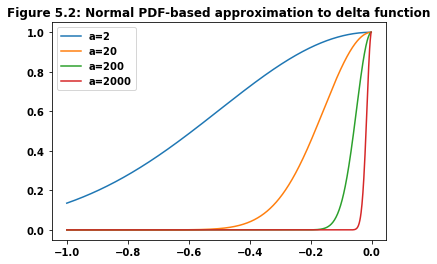

In [18]:
#Illustrate smoothed delta function

def delta_norm(x,a):
    exparg=a*(x**2)
    return(a*np.exp(np.sign(x)*min(exparg,600)))

x=np.arange(-1.,-.001,.001)
for a in [2,20,200,2000]:
    scale=delta_norm(x[-1],a)
    y=[delta_norm(xx,a)/scale for xx in x]
    plt.plot(x,y,label="a="+str(a))

plt.title("Figure 5.2: Normal PDF-based approximation to delta function")
plt.legend()
plt.show();


In practice another parameter $\omega$ is used to balance the effect of the indicator function against the rest of the objective function. We'll use $\delta_{norm}$ as the smoothed indicator function in what follows, but we'll shift to the more general notation $\delta_{sm}$ to indicate that other smoothed indicator functions can be used. 

\eqref{eq:convex_barrier} is therefore changed to:
$$\text{minimize}_{x} \quad \omega f(x)+\sum_{i=1}^{k_{ineq}} \delta_{sm}(g_i(x))$$
$$\text{subject to }Ax=b, \text{rowdim}(A)=\text{rowdim}(b)=k_{eq}
\label{eq:convex_barrier_smooth}\tag{5.51}$$
If $g_i(x)<0$ as desired, $\delta_{sm}(g_i(x))$ is comparatively small. Once $g_i(x)$ goes positive, $\delta_{sm}(g_i(x))$ goes to an increasingly unpleasant large positive number, which the optimizer will seek to avoid. Solving \eqref{eq:convex_barrier_smooth} with small $\omega$ is really just finding a feasible point.

After a solution is obtained for a given level of $\omega$, it can be used as the starting point for a tougher optimization with a bigger $\omega$ that gives more emphasis on minimizing $f(x)$. Eventually this process will converge on a solution that satisfies the constraints and minimizes $f(x)$.

The **`Barrier Algorithm`**[$^5$](#five_footnotes) to solve \eqref{eq:convex_barrier} looks like this:
>Barrier Algorithm
>1. Set parameters $\omega_0>0$, $\alpha>1$, $\epsilon>0$. Find an initial feasible point $x$ of the problem \eqref{eq:convex_barrier}. Set $\omega=\omega_0$.
2. Perform the optimization \eqref{eq:convex_barrier_smooth} using an iterative technique on its Lagrangian, starting at initial point $x$. Call the result $x(\omega)$.
3. Set $x=x(\omega)$.
4. If $k_{eq}/\omega<\epsilon$, stop with solution $x$. Otherwise set $\omega=\alpha\omega$ and go back to step 2.

We'll illustrate this method by solving a simple problem based on the efficient frontier optimizations in Chapter 4. We'll just look for a minimum variance portfolio subject to a budget constraint and subject to a convex constraint that the sum of the squares of the weights is less than $.4$.
$$\text{minimize}_x \frac{1}{2}w^{\intercal}Cw$$
$$\text{subject to }w^{\intercal}u=1,\quad w^{\intercal}w\leq.4$$

As usual the dimension of the vectors is $n$ and $u$ is an $n$-vector of all ones. Using the encoding process for the budget constraint, let $w_0$ be an $n$-vector of all zeros except for a one in the $n^{th}$ place. Let $N$ be an $n\times (n-1)$ matrix with the $(n-1)\times(n-1)$ identity matrix in the first $n-1$ rows, and a row of all $-1$s in the last row.
$$w_0=
  \left [\begin{array}{c}
   0 \\
   \vdots \\
   0 \\
   1 \\
  \end{array} \right]
\qquad
N=
  \left[ \begin{array}{c}
   I_{n-1} \\
   -u_{n-1}^{\intercal} \\
  \end{array} \right]
$$
Then for any $(n-1)$-vector $x$, the $n$-vector $w_0+Nx$ satisfies the budget constraint since
$$u_n^{\intercal}(w_0+Nx)=1+u_{n-1}^{\intercal}I_{n-1}x-u_{n-1}^{\intercal}x=1$$

The objective function becomes
$$\frac{1}{2}w^{\intercal}Cw=\frac{1}{2}(w_0+Nx)^{\intercal}C(w_0+Nx)
=\frac{1}{2}x^{\intercal}Fx+w_0^{\intercal}CNx+const.$$
where $F=N^{\intercal}CN$. Dropping the constant, the unconstrained objective (as in \eqref{eq:convex_barrier_smooth}) is to
$$\text{minimize}_x \quad\omega\bigl(\frac{1}{2}x^{\intercal}Fx+w_0^{\intercal}CNx\bigr)+
\delta_{sm}((w_0+Nx)^{\intercal}(w_0+Nx)-.4)$$

Further simplification:
$$w_0^{\intercal}w_0=1;\quad w_0^{\intercal}Nx=-u_{n-1}^{\intercal}x;
\quad x^{\intercal}N^{\intercal}Nx=x^{\intercal}x+(u_{n-1}^{\intercal}x)^2$$
The unconstrained problem simplifies to
$$\text{minimize}_x \quad\omega\bigl(\frac{1}{2}x^{\intercal}Fx+w_0^{\intercal}CNx\bigr)+
\delta_{sm}((u_{n-1}^{\intercal}x-1)^2+x^{\intercal}x-.4)$$

We'll use the same Swiss Franc/Pound/Yen data as was used in Chapter 4 to create the $C$ matrix. That data is brought in by the next code segment:

In [19]:
import pandas as pd
import qrpm_funcs as qf
#Get 3 currencies until the end of
#previous year. Form sample covariance matrix

lastday=qf.LastYearEnd()
#Swiss franc, pound sterling, Japanese Yen
seriesnames=['DEXSZUS','DEXUSUK','DEXJPUS']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,enddate=lastday)
multipliers=[-1,1,-1]

lgdates,difflgs=qf.levels_to_log_returns(cdates,ratematrix,multipliers)

#Mean vector and covariance matrix are inputs to efficient frontier calculations
d=np.array(difflgs)
m=np.mean(d,axis=0)
c=np.cov(d.T)

The initial point will be $x_{init}=(\frac{1}{2},\frac{1}{4})$, so that $w_{init}=(\frac{1}{2},\frac{1}{4},\frac{1}{4})$.

For accuracy and speed of convergence, the non-barrier part of the objective function will be scaled to be on the order of $1$. Initial parameters are $\omega_0=1$, $\epsilon=10^{-8}$.

The next segment runs the first pass of the barrier algorithm.

In [20]:
#Do the optimization:
#minimize 1/2*w'Cw
#Subject to w'u=1
#           sum(wi^2)<= k
#where w is n-vector, u is unit n-vector

#Change to unconstrained barrier function where
# w=w0+Nx, x an n-1 vector.
#w0 is vector of all zeroes except for 1 in nth place
#N is nx(n-1) matrix with (n-1)x(n-1) identity matrix I(n-1) in first
#n-1 rows, -u(n-1) in last row (u(n-1) unit vector of size n-1)
#This gives function to be minimized over x:
# f(x)=omega*((1/2)*x'Fx+x'N'Cw0)-delta((u(n-1)'x-1)^2+x'x-k)

#Parameters
omega=1
epsilon=10**(-8)
k_parameter=.4

def delta_smooth(x):
    #Compute smoothed delta function
    a=2000.
    exparg=a*x**2
    return(a*np.exp(np.sign(x)*min(exparg,600.)))

def barrierfunc(x):
    global k_parameter, omega, c, epsilon, order_magnitude
    #Create N matrix
    n=len(x)+1
    nmatrix=np.vstack([np.identity(n-1),[-1]*(n-1)])
    #Create w0 vector
    w0=[0]*(n-1)+[1]
    #Create F matrix = N'CN
    fmatrix=(nmatrix.T @ c) @ nmatrix
    #First part of objective function 1/2*x'Fx
    objfunction=((x @ fmatrix) @ x)/2.
    #Second part of objective function w0'CNx
    objfunction+=(w0 @ (c @ nmatrix)) @ x
    #Make order of magnitude of this part about one - otherwise convergence is slow
    if order_magnitude == 0.:
        order_magnitude=np.abs(objfunction)
    objfunction*=(omega/order_magnitude)
    #Add in barrier
    u_times_x=sum(x)
    arg_delta = (u_times_x-1)**2 + (np.array(x) @ x) - k_parameter
    objfunction+=delta_smooth(arg_delta)
    return(objfunction)

def barriergrad(x):
    #Take gradient of function by differencing
    n=len(x)
    epsilon=10**(-8)/n
    bf_x=barrierfunc(x)

    gradvec=np.array([-bf_x]*n)
    for i in range(n):    #perturb each argument a little
        little_vec=np.zeros(n)
        little_vec[i]=epsilon
        gradvec[i]+=barrierfunc(np.add(x,little_vec))
    gradvec/=epsilon
    return(gradvec)

#Run initial step of barrier algorithm
i=0
xinit=[1/2,1/4]

order_magnitude=0.
x=gradientmethod([xinit],barrierfunc,barriergrad,True)

print("optimal x:",x[-1],1-sum(x[-1]))
print("iterations:",len(x)-1)
print("optimal objective:",barrierfunc(x[-1]))
print("gradient:",barriergrad(x[-1]))

#Pass on initial value for Barrier Algorithm iterations
xinit=x[-1]

Initial point: [0.5, 0.25]
Objective function at initial point: 572.0095937203789
Gradient at initial point: [2.86529901e+04 3.81987775e-02]
0  obj: 572.0095937203789  grad^2: 820993843.7308449
Delta from backtracking: 2.3864747990995235e-06
1  obj: 12.768453271095378  grad^2: 541530.1485572453
Delta from backtracking: 7.533931929047496e-05
2  obj: -0.09288542514530174  grad^2: 1893.775482237069
Delta from backtracking: 0.0017838067156503712
3  obj: -1.054800646845617  grad^2: 8.426110061631583
Delta from backtracking: 0.0031712119389339932
4  obj: -1.062673480054419  grad^2: 1.9414162883166184
Delta from backtracking: 0.0031712119389339932
5  obj: -1.0644352062234936  grad^2: 0.47073322317722044
Delta from backtracking: 0.0031712119389339932
6  obj: -1.0648886764972436  grad^2: 0.10756901910054678
Delta from backtracking: 0.0031712119389339932
7  obj: -1.0649917864283562  grad^2: 0.02536190642741909
Delta from backtracking: 0.0031712119389339932
8  obj: -1.06501658682627  grad^2: 0.00

The gradient descent method got an answer that is roughly equal-weighted.

The next segment uses that solution as the initial point for the next optimization with a bigger $\omega$. The algorithm says to iterate until $\frac{k_{eq}}{\omega}<\epsilon$, but we don't have any explicit equality constraints left. We'll just do five iterations, increasing $\omega$ by a factor of $10$ each time:

In [21]:
#Iterate the barrier method using starting
#value from previous code segment

alpha=10
iter_barrier=1
omega*=alpha

while True:

    x=gradientmethod([xinit],barrierfunc,barriergrad,False)
    
    print("barrier iteration ",iter_barrier)
    print("optimal x:",x[-1],1-sum(x[-1]))
    print("iterations:",len(x)-1)
    print("optimal objective:",barrierfunc(x[-1]))
    print("gradient:",barriergrad(x[-1]))

    if iter_barrier == 5:
        break   #Done
        
    #Keep going with a bigger omega
    #Use solution as initial guess for next pass
    xinit=x[-1]
    iter_barrier+=1
    omega*=alpha


barrier iteration  1
optimal x: [0.30180644 0.35144947] 0.34674408650332245
iterations: 15
optimal objective: -9.855995919080867
gradient: [-1.17239551e-05 -2.80664381e-05]
barrier iteration  2
optimal x: [0.26444077 0.37380701] 0.3617522207132179
iterations: 19
optimal objective: -101.73689269123221
gradient: [-5.11590770e-05 -3.41060513e-05]
barrier iteration  3
optimal x: [0.23193106 0.39393848] 0.3741304563642358
iterations: 23
optimal objective: -1013.539521323303
gradient: [ 4.54747351e-05 -4.54747351e-05]
barrier iteration  4
optimal x: [0.20030194 0.41405373] 0.3856443351111212
iterations: 501
optimal objective: -10108.31594256287
gradient: [0.00145519 0.0007276 ]
barrier iteration  5
optimal x: [0.15873136 0.44118304] 0.4000855930590287
iterations: 501
optimal objective: -101033.80926308232
gradient: [0.00582077 0.00582077]


Because of the binding constraint $w^{\intercal}w\leq.4$, the solution has a more even distribution of weights than the unconstrained solution in 4.15#.

Of course the reason to do the barrier algorithm is not on such straightforward problems with $n=3$. In commercial use, there may be thousands or tens of thousands of assets being considered, and a host of portfolio construction constraints, including perhaps regulatory and tax considerations. In that case a convex optimization might find satisfactory optimal portfolios that no amount of human intuition could find.

Fortunately, many elegant and powerful packages exist to do convex optimization. That's the good news. The bad news was given at the beginning of this chapter: if the user is not aware of how optimization works, algorithm failure or nonsensical results will quickly arise. But in the hands of a skilled user &mdash; perhaps yourself after this chapter? &mdash; convex optimization packages can solve tough problems.

One such package for Python is [based on the Boyd and Vandenberghe book](https://cvxopt.org).[$^1$](#five_footnotes) To close this chapter, we've repeated the long-only optimization (4.22) using the Boyd, Vandenberghe, et. al. cvoxpt package.

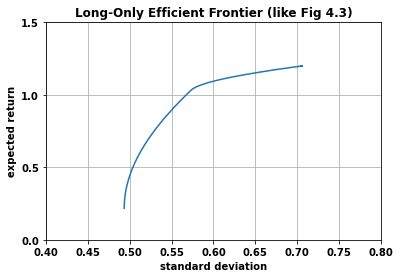

In [23]:
# Modified from cvxopt - originally for Figure 4.12 in Boyd
# and Vandenberghe book. https://cvxopt.org/install/

from cvxopt import matrix
from cvxopt.blas import dot
from cvxopt.solvers import qp, options

n = 3
S = matrix(c)
pbar = matrix(m)

G = matrix(0.0, (n,n))
G[::n+1] = -1.0
h = matrix(0.0, (n,1))
A = matrix(1.0, (1,n))
b = matrix(1.0)

N = 100
mus = [ 10**(5.0*t/N-1.0) for t in range(N) ]
options['show_progress'] = False
xs = [ qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus ]

returns = [ dot(pbar,x) for x in xs ]
risks = [ np.sqrt(dot(x, S*x)) for x in xs ]

plt.plot(np.multiply(100.,risks), np.multiply(10000.,returns))
plt.xlabel('standard deviation')
plt.ylabel('expected return')
plt.axis([0.4, 0.8, 0, 1.5])
plt.grid()
plt.title('Long-Only Efficient Frontier (like Fig 4.3)')
plt.yticks([0.0, 0.5, 1.0, 1.5])
plt.show();

# Chapter 5 Footnotes #
<a name="five_footnotes"></a>

$^1$ Boyd, Stephen and Vandenberghe, Lieven (2004). *Convex Optimization.* Cambrdige University Press. https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf
<br>

$^2$ Bertsekas, Dimitri (1996). *Constrained Optimization and Lagrange Multiplier Methods.* Athena Scientific, Belmont, Mass.
<br>

$^3$ Boyd and Vandenberghe, pp. 466 ff.
<br>

$^4$ Until about the year 2000, Karush's name was not included in what were just called the "Kuhn-Tucker" conditions based on [Kuhn and Tucker's 1951 paper](https://projecteuclid.org/euclid.bsmsp/1200500249). For example, Bertsekas's 1996 text does not mention Karush. However some [mathematical history detective work](https://doi.org/10.1006/hmat.2000.2289) found that William Karush had predated Kuhn and Tucker in his [1939 Master's Thesis](https://catalog.lib.uchicago.edu/vufind/Record/4111654). Boyd and Vandenberghe's 2004 text refers to Karush-Kuhn-Tucker.
<br>

$^5$ Fiacco, A. V. and McCormick, G. P. (1968). *Nonlinear Programming: Sequential Unconstrained Minimization Techniques.* Wiley, NY. 1990 reprinting at https://books.google.com/books?id=icWjpwgigkAC.
